In [1]:
from __future__ import division
import argparse
import logging

import numpy as np
import torch.autograd
import torch.cuda
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import random

import copy
from datasets.maps_alt import MAPSDataset

#from cnn_ws.transformations.homography_augmentation import HomographyAugmentation
from cnn_ws.losses.cosine_loss import CosineLoss

from cnn_ws.models.myphocnet import PHOCNet
from cnn_ws.evaluation.retrieval import map_from_feature_matrix, map_from_query_test_feature_matrices
from torch.utils.data.dataloader import _DataLoaderIter as DataLoaderIter
from torch.utils.data.sampler import WeightedRandomSampler

from cnn_ws.utils.save_load import my_torch_save, my_torch_load

import matplotlib.pyplot as plt

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
word_filter_len = 1 # only words above this length are considered valid
max_var_len = 1

In [3]:
if not torch.cuda.is_available():
    logger.warning('Could not find CUDA environment, using CPU mode')
    gpu_id = None
else:
    gpu_id = [0]
#torch.cuda.get_device_name(gpu_id[0])
pass

In [4]:
model_ = torch.load('models/PHOCNet_Nov13.pt')
cnn = model_.module#list(model_.named_parameters())
if gpu_id is not None:
        if len(gpu_id) > 1:
            cnn = nn.DataParallel(cnn, device_ids=gpu_id)
            cnn.cuda()
        else:
            cnn.cuda(gpu_id[0])
cnn.training = False

In [5]:
A = ['D0042-1070001']

In [6]:
from strlocale import BasicLocale

def clean_words(words):
    lc = BasicLocale()
    for i, w in enumerate(words):
        try:
            words[i] = lc.represent(w).encode('ascii',errors='ignore')
        except:
            words[i] = w
    return words

# load before, after images and words, transforms and cleans them
# the function also assumes that ground truth words are the same before and after
# returns before_images, after_images, words
def load_and_transform(map_name):
    images_before = np.load('../detection_outputs_ready_for_test/ray_regions_normal_before/'+map_name+'.npy')
    words_before = np.load('../detection_outputs_ready_for_test/ray_labels_normal_before/'+map_name+'.npy')
    words_before = clean_words(words_before)
    images_before, words_before = clean_word_images(images_before, words_before)
    images_before = np.transpose(images_before, (0,3,1,2))
    
    images_after = np.load('../detection_outputs_ready_for_test/ray_regions_normal_after/'+map_name+'.npy')
    words_after = np.load('../detection_outputs_ready_for_test/ray_labels_normal_after/'+map_name+'.npy')
    words_after = clean_words(words_after)
    images_after, words_after = clean_word_images(images_after, words_after)
    images_after = np.transpose(images_after, (0,3,1,2))
    
    print 'Images Before Shape ', images_before.shape
    print 'Words Before Shape ', words_before.shape
    print 'Images After Shape ', images_after.shape
    print 'Words After Shape ', words_after.shape
    return images_before, images_after, words_after

def clean_word_images(images, words):
    selected_idx = [x for x in range(len(words)) if len(words[x]) > word_filter_len]
    images = images[selected_idx]
    words = words[selected_idx]
    return images, words

In [7]:
images_before, images_after, words = load_and_transform(A[0])

Images Before Shape  (1078, 3, 135, 487)
Words Before Shape  (1078,)
Images After Shape  (1078, 3, 135, 487)
Words After Shape  (1078,)


In [8]:
# convert image tnto embedding using the cnn model
def get_image_embeddings(images):
    outputs = []
    for i in tqdm(range(len(images))):
        word_img = images[i]
        word_img = 1 - word_img.astype(np.float32) / 255.0
        word_img = word_img.reshape((1,) + word_img.shape)
        word_img = torch.from_numpy(word_img).float()
        word_img = word_img.cuda(gpu_id[0])
        word_img = torch.autograd.Variable(word_img)
        output = torch.sigmoid(cnn(word_img))
        output = output.data.cpu().numpy().flatten()
        outputs.append(output)
    return outputs

outputs_before = get_image_embeddings(images_before)
outputs_after = get_image_embeddings(images_after)

100%|██████████| 1078/1078 [00:17<00:00, 62.89it/s]


In [9]:
def insert_dict_set(dct, key, val):
    if key not in dct:
        dct[key] = set()
    dct[key].add(val)
    
# the method defines the rules to handle multiple dir associated with a given word
# returns conf_words which is a set of word_var where this confusion exists
# word_var: dictionary from word -> chosen_dir. Incase a word has multiple dir
# the following preference order is followed 0 > (1,-1) > (2,-2) > (3,-3) ...
def handle_word_conf(comp_word_var):
    word_var = {}
    conf_words = set()
    for var in comp_word_var.keys():
        dirs = np.array(list(comp_word_var[var]))
        if(len(dirs) == 1):
            word_var[var] = dirs[0]
        else:
            conf_words.add(var)
            idx = np.argmin(np.abs(dirs))
            word_var[var] = dirs[idx]
    return word_var, conf_words

# function to create word variations
# word_var is a dictionary that contains all variations as key and 0,1,-1 as value
# 0 denotes the root word, -1 denotes var = root_word[:-1], +1 denotes var = root_word[1:]
# root_word_var is a dict that stores original_word => all_variations
# enable_conf: boolean flag that controls if the confusion logic should be used.
# when enabled if a word is a root word as well as a word variation (happens if root words ar rand and grand)
# it marks it as to be extended and also stores it in the confusion list
def create_word_variations(words, enable_conf=False):
    word_var = {}
    root_word_var = {}
    # create the root word variation dict and set word_var as -1 or +1
    for w in words:
        root_var_list = [w, w.lower(), w.upper(), w.capitalize()]
        var_set = set()
        for var in root_var_list:
            for l in range(1,max_var_len+1):
                if len(w) <= l:
                    continue
                insert_dict_set(word_var, var, 0)
                insert_dict_set(word_var, var[l:], l)
                insert_dict_set(word_var, var[:-l], -l)
                var_set.add(var)
                var_set.add(var[l:])
                var_set.add(var[:-l])
        root_word_var[w] = var_set
    word_var, conf_words = handle_word_conf(word_var)
    return word_var, root_word_var, conf_words

In [10]:
# compute the PHOC representation of the word itself
from cnn_ws.string_embeddings.phoc import build_phoc_descriptor
def get_word_phoc_representations(word_strings):
    unigrams = [chr(i) for i in range(ord('&'), ord('&')+1) + range(ord('A'), ord('Z')+1) + \
                    range(ord('a'), ord('z') + 1) + range(ord('0'), ord('9') + 1)]
    bigram_levels = None
    bigrams = None
    phoc_unigram_levels=(1, 2, 4, 8)
    word_var_dir, root_word_var, conf_words = create_word_variations(word_strings, enable_conf=False)
    
    word_var_strings = word_var_dir.keys()
    embedding_var = build_phoc_descriptor(words=word_var_strings,
                                  phoc_unigrams=unigrams,
                                  bigram_levels=bigram_levels,
                                  phoc_bigrams=bigrams,
                                  unigram_levels=phoc_unigram_levels)
    
    print('embedding variations:', embedding_var.shape)
    return (embedding_var, word_var_strings, word_var_dir, root_word_var, conf_words)

emb_info = get_word_phoc_representations(words)

100%|██████████| 1813/1813 [00:00<00:00, 5169.37it/s]

('embedding variations:', (1813, 945))


In [11]:
# gets the embeddings for images before, images after and the ground truth word embeddings
def get_emb_images_words(outputs_before, outputs_after, words, emb_info):
    embedding_var, word_var_strings, word_var_dir, root_word_var, _ = emb_info
    emb_list = []
    for i in range(len(words)):
        for j in range(len(word_var_strings)):
            if(word_var_strings[j] == words[i]):
                emb_list.append([outputs_before[i], outputs_after[i], embedding_var[j]])
                break
    return emb_list
emb_list = get_emb_images_words(outputs_before, outputs_after, words, emb_info)

In [15]:
phoc_len = 63 # number of characters supported by phoc

# function to display the heatmap
def show_heatmap(emb, title, labels):
    plt.figure(figsize=(20, 20), dpi=100, facecolor='w', edgecolor='k')
    plt.xticks(np.arange(0, emb.shape[1]+1, 1), np.array(labels))
    plt.yticks(np.arange(0, emb.shape[0]+1, 1))
    # plt.title(title)
    plt.imshow(emb, cmap='binary', interpolation='nearest')
    plt.show()

# given an embedding array for an image, plots a heatmap of the embeddings
# for the actual text word, embeddings of original image and embedding
# of image after transformation (extension).
# all_embs: all the embeddings of a particular image obtained from get_emb_images_words
# word: The ground truth word
# level: The PHOC level that needs to be plotted [1,2,3,4]
# only_alphabets: boolean if True plots only alphabets on the heatmap (leaving out the digits and special characters)
def embedding_heatmap(all_embs, word, level, only_alphabets):
    if level == 1:
        l = 0
        r = phoc_len
    elif level == 2:
        l = phoc_len
        r = phoc_len*3
    elif level == 3:
        l = phoc_len*3
        r = phoc_len*7
    else:
        l = phoc_len*7
        r = phoc_len*15

    print 'Level',level,' PHOC embeddings for',word
    rows = (int)((r-l)/phoc_len)
    emb_word = all_embs[2][l:r].reshape(rows,phoc_len)
    emb_before = all_embs[0][l:r].reshape(rows,phoc_len)
    emb_after = all_embs[1][l:r].reshape(rows,phoc_len)

    if only_alphabets:
        unigrams = [chr(i) for i in range(ord('A'), ord('Z')+1) + range(ord('a'), ord('z') + 1)]
        lidx = 1
        ridx = 53
    else:
        unigrams = [chr(i) for i in range(ord('&'), ord('&')+1) + range(ord('A'), ord('Z')+1) + \
                    range(ord('a'), ord('z') + 1) + range(ord('0'), ord('9') + 1)]
        lidx = 0
        ridx = 63
    
    show_heatmap(emb_word[:,lidx:ridx], 'Heatmap for word text embedding', unigrams)
    show_heatmap(emb_before[:,lidx:ridx], 'Heatmap for before image embedding', unigrams)
    show_heatmap(emb_after[:,lidx:ridx], 'Heatmap for after image embedding', unigrams)

## Plot Description
* Three plots will be made
    * Heatmap for word text embedding
    * Heatmap for before image embedding
    * Heatmap for after image embedding
* Each plot may be nxd depending on the level being visualized e.g At level 1, n=1. At level 2, n=2, At level 3, n=4 and at level 4, n=8
* Black squares on the heatmap represent 1, while white squares represent 0, and greys the values in between
* embedding_heatmap plots the embedding. Just use the index of images to get embeddings and ground truth word to pass into embedding_heatmap. Image indexes can be found from the last celll in the notebook. e.g The below cell plots embeddings for RANDOLPH (index 22) at level 1.

## Analysis
* Still working on analyzing the embeddings
* Some things that I could observe is that the embeddings in general become more noisy (deviate more from ground truth embedding) after the extension was done

Level 2  PHOC embeddings for FAIRFIELD


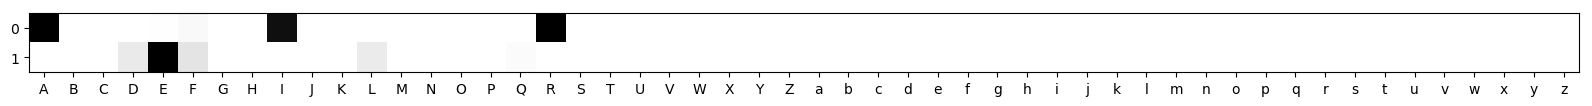

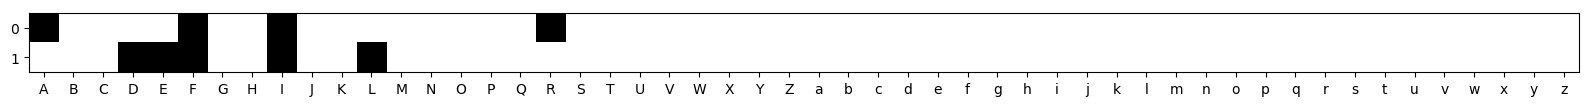

In [18]:
# print(len(emb_list), len(words))
embedding_heatmap(emb_list[63], words[63], 2, True)